<a href="https://colab.research.google.com/github/igordantasgf/analise_dados_microambientais/blob/main/fly_eye_visualize.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [3]:
col = ['TIMESTAMP', '"RECORD"', '"rtime"', '"batt_volt"', '"panel_temp"', '"CM3Up_mv_Avg"', '"CM3Up_Wm2_Avg"', '"CMP21_Avg"', '"CMP21_Wm2_Avg"', '"CelSol_01_Avg"', '"CelSol_02_Avg"', '"CelSol_03_Avg"', '"CelSol_04_Avg"', '"CelSol_05_Avg"', '"CelSol_06_Avg"', '"CelSol_07_Avg"', '"CelSol_08_Avg"', '"CelSol_09_Avg"', '"CelSol_10_Avg"', '"CelSol_11_Avg"', '"CelSol_12_Avg"', '"CelSol_13_Avg"', '"CelSol_14_Avg"', '"CelSol_15_Avg"', '"CelSol_16_Avg"', '"CelSol_17_Avg"']
labmim = pd.read_csv('/content/drive/MyDrive/Bolsa - Edson/plataforma/LBM_solar_2022.dat',sep=';', header=None,skiprows=lambda x:x in [0,1,2,3], names=col)
labmim[col] = labmim.TIMESTAMP.str.split(",", expand = True)

In [4]:
def calcular_nan():
  count = labmim.isna().any(axis=1).sum()
  print(f"Number of rows with at least one NaN value: {count}")
  print(f"Total rows in series: {len(labmim)}")
calcular_nan()

Number of rows with at least one NaN value: 0
Total rows in series: 459301


### Organização dos valores
##### Sequenciamento dos valores e suas respectivas coordenadas bidimensionais em duas litas separadas 

In [49]:
sensors=col[9:]
values=[]

grau=np.radians([90,135,180,225,270,315,360,45,90,135,180,225,270,315,360,45,0])
altura=np.array([100,100,100,100,100,100,100,100,50,50,50,50,50,50,50,50,0])
coord=[]
for a,b in zip(grau,altura):
  coord.append([a,b])

labmim_backup = labmim

for i in sensors:
  x=0
  unique_types = set()
  #for item in labmim_backup[i]:
  #  unique_types.add(type(item))
  #print(unique_types)
  labmim_backup[i] = [int(x) if str(x).isdigit() else 0 for x in labmim_backup[i]]
  values.append(sum(labmim_backup[i]))

values = np.array(values)

In [57]:
""" CORRIGIR CÓDIGO ABAIXO """

#plt.subplot(projection="polar")
#plt.pcolormesh(coord, values, cmap="coolwarm", shading='auto')
#plt.colorbar()
#plt.show()

' CORRIGIR CÓDIGO ABAIXO'

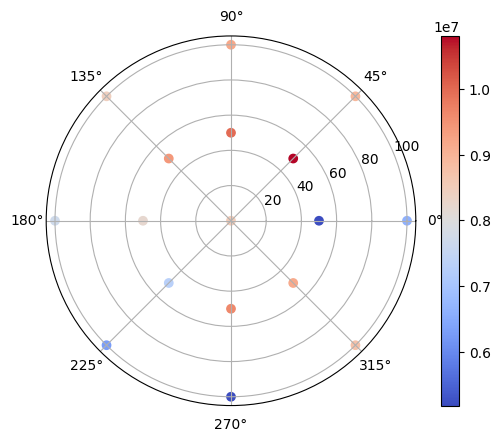

In [58]:
rad = np.radians(data[1])
azm = data[0]
z = data[2]

plt.subplot(projection="polar")
plt.scatter(grau, altura, c=values, cmap='coolwarm')
plt.colorbar()
plt.show()

In [37]:
grau

array([1.57079633, 2.35619449, 3.14159265, 3.92699082, 4.71238898,
       5.49778714, 6.28318531, 0.78539816, 1.57079633, 2.35619449,
       3.14159265, 3.92699082, 4.71238898, 5.49778714, 6.28318531,
       0.78539816, 0.        ])

In [38]:
altura

array([100, 100, 100, 100, 100, 100, 100, 100,  50,  50,  50,  50,  50,
        50,  50,  50,   0])

In [39]:
values

array([ 9193338,  8456400,  7708758,  6284256,  5188114,  8744490,
        6627322,  8936112,  9984239,  9424400,  8200163,  7292308,
        9630627,  9153611,  5179864, 10811614,  8548850])